In [34]:
import pandas as pd
import numpy as np
import sklearn.datasets
import pandas_profiling
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pydotplus
from IPython.display import Image
import matplotlib.pyplot as plt

from pdpbox import pdp
from yellowbrick.model_selection import ValidationCurve
from yellowbrick.classifier import ClassificationReport, ClassPredictionError
import shap

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [7]:
np.random.seed(42)

# load wine dataset
raw_df = sklearn.datasets.load_wine()

# take a look at it
features = pd.DataFrame(raw_df['data'], columns=raw_df['feature_names'])
targets = pd.DataFrame(raw_df['target'], columns=['target'])
print(raw_df['DESCR'])

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            1

In [8]:
# take a look at the sample data
df = pd.concat([features, targets], axis=1)

df.head()

alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   od280/od315_of_diluted_wines  proline  target  
0                          3.92   1065.0       0  
1                          3.40   1050.0       0  
2                          3.17   1185.0       0  
3                          3.45   1480.0       0  
4                          2.93    735.0       0

In [9]:
# use pandas profiling to understand the data a little bit more
df.profile_report()

In [10]:
# first we randomly select 100 rows in the dataset to create a tree with no pruning
train_df = df.sample(100)
tree_model1 = DecisionTreeClassifier().fit(train_df.drop('target', axis=1), train_df['target'])

In [11]:
# helper function to visualise the tree
def visualise_tree(model,
                   feature_name=raw_df['feature_names'],
                   class_names=raw_df['target_names']):
    dot_data = export_graphviz(model,
                               out_file=None,
                               feature_names=feature_name,
                               class_names=class_names,
                               rounded=True,
                               proportion=False,
                               precision=2,
                               filled=True)

    graph = pydotplus.graph_from_dot_data(dot_data)
    return graph.create_png()

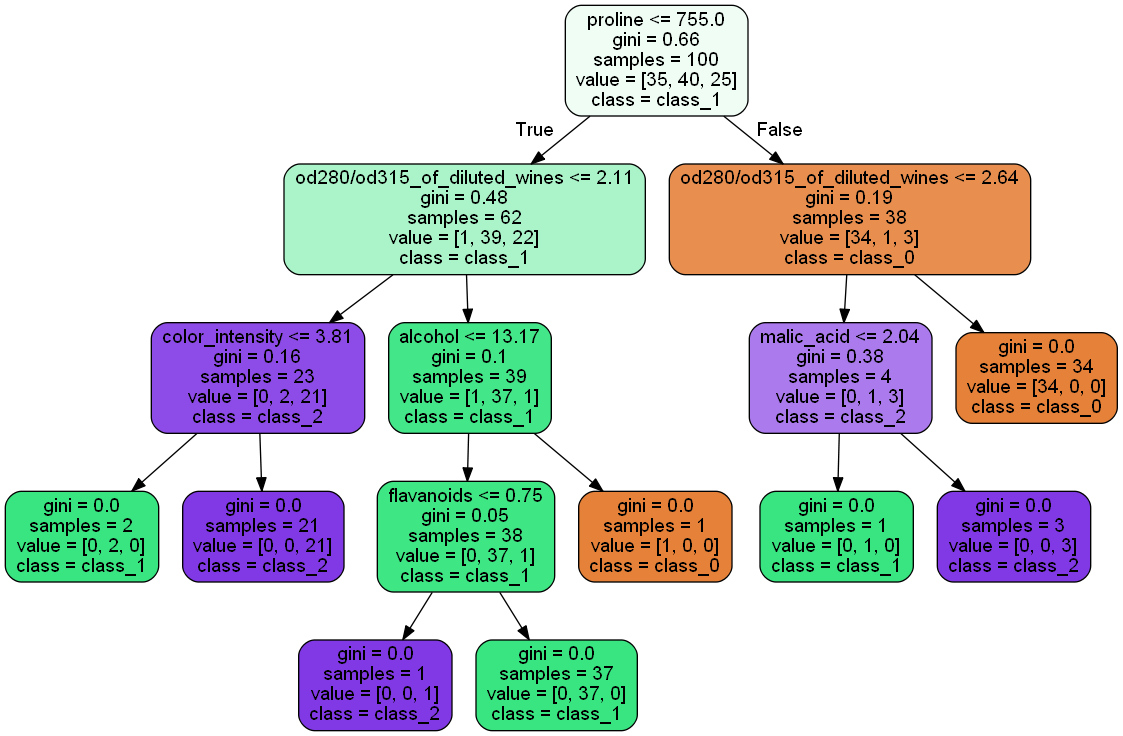

In [12]:
# Let's visualise the tree
Image(visualise_tree(tree_model1))

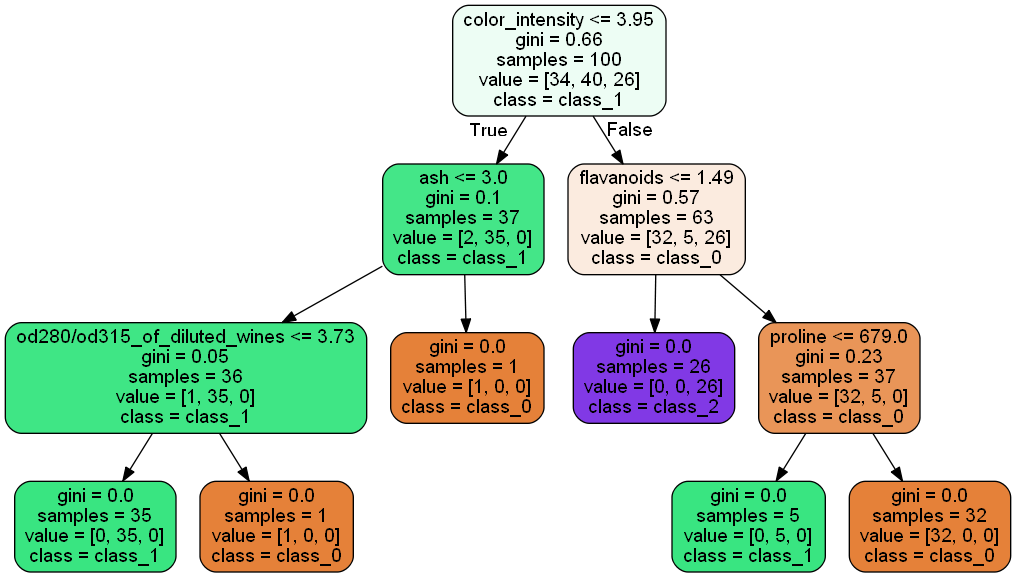

In [13]:
# now we use resample another 100 more data points, observe difference in tree structure
train_df = df.sample(100)
tree_model2 = DecisionTreeClassifier().fit(train_df.drop('target', axis=1), train_df['target'])
Image(visualise_tree(tree_model2))

Cost Function:
- categorical: Gini Index, Entropy
- numeric: variance

In [14]:
# generate training and testing data
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.33, random_state=42)

In [15]:
# Create a random forest 
rf_model = RandomForestClassifier(random_state=42).fit(X_train, y_train)

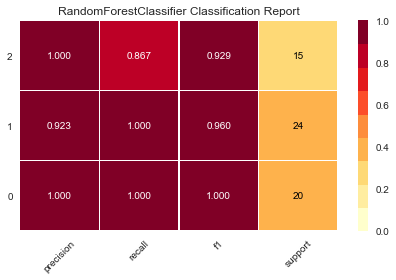

In [16]:
# Create classification report
reporter = ClassificationReport(rf_model, classes=[0,1,2], support=True)

reporter.fit(X_train, y_train)
reporter.score(X_test, y_test)
reporter.poof()

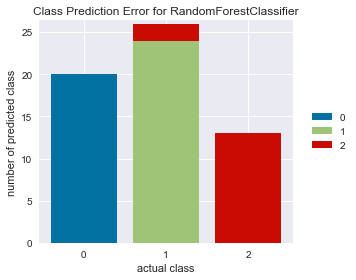

In [17]:
# Create class prediction error
visualizer = ClassPredictionError(rf_model, classes=[0,1,2])

visualizer.fit(X_train, y_train['target'])
visualizer.score(X_test, y_test['target'])
visualizer.poof()

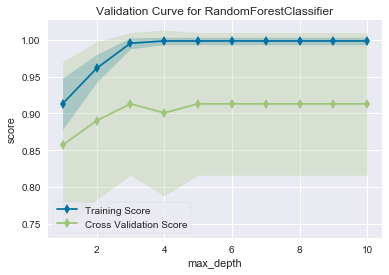

In [18]:
# Create single feature validation curve
viz = ValidationCurve(RandomForestClassifier(random_state=42), param_name="max_depth",
                      param_range=np.arange(1, 11), cv=10, scoring="r2")
viz.fit(X_train, y_train)
viz.poof()

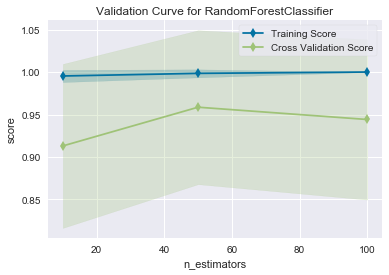

In [19]:
viz = ValidationCurve(RandomForestClassifier(max_depth=3, random_state=42), param_name="n_estimators",
                      param_range=[10, 50, 100], cv=10, scoring="r2")
viz.fit(X_train, y_train)
viz.poof()

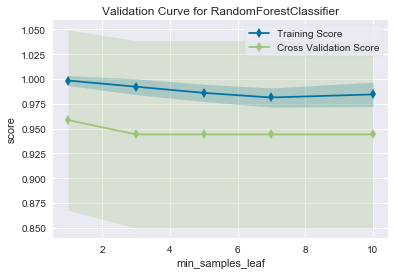

In [20]:
viz = ValidationCurve(RandomForestClassifier(max_depth=3, n_estimators=50, random_state=42), param_name="min_samples_leaf",
                      param_range=[1, 3, 5, 7, 10], cv=10, scoring="r2")
viz.fit(X_train, y_train)
viz.poof()

In [21]:
# retrain the model with the best found parameters
rf_model = RandomForestClassifier(max_depth=3, 
                                  n_estimators=50,
                                  min_samples_leaf=1,
                                  random_state=42).fit(X_train, y_train)

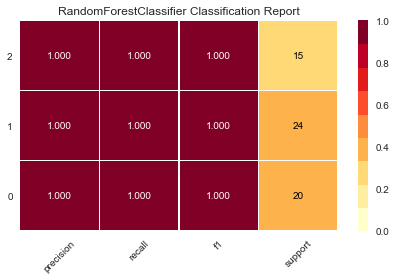

In [22]:
# Create classification report
reporter = ClassificationReport(rf_model, classes=[0,1,2], support=True)

reporter.fit(X_train, y_train)
reporter.score(X_test, y_test)
reporter.poof()

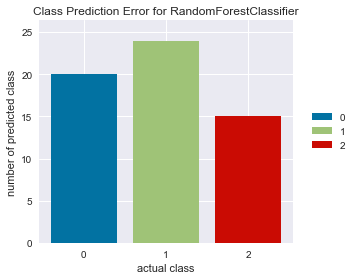

In [23]:
# Create class prediction error
visualizer = ClassPredictionError(rf_model, classes=[0,1,2])

visualizer.fit(X_train, y_train['target'])
visualizer.score(X_test, y_test['target'])
visualizer.poof()

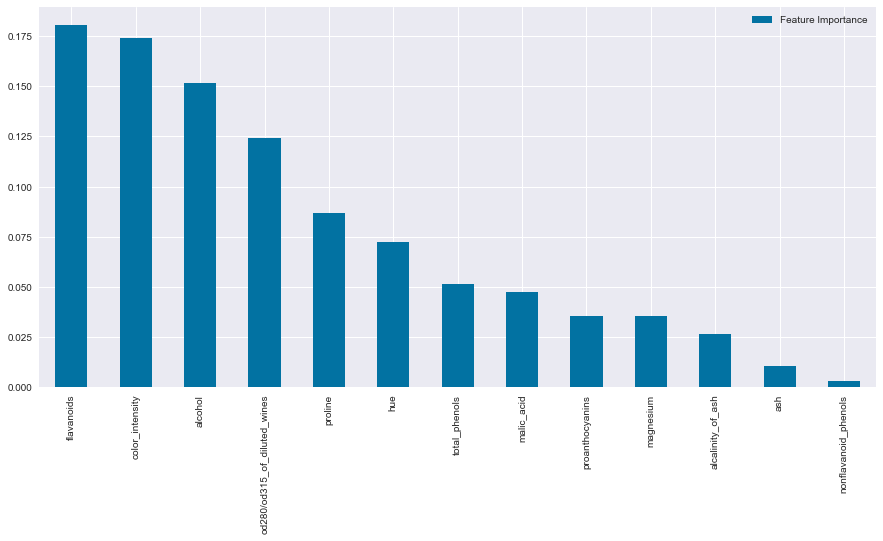

In [25]:
# basic feature importance
pd.DataFrame(rf_model.feature_importances_, 
             index=X_train.columns,
             columns=['Feature Importance']).sort_values(by='Feature Importance', 
                                                         ascending=False).plot(kind='bar', 
                                                                               figsize=(15,7))

In [26]:
# partial dependency plots
def individual_pdp(model, feature_list, train_df):
    for feature in feature_list:
        pdp_model = pdp.pdp_isolate(model=model, dataset=train_df, model_features=feature_list, feature=feature)
        fig, axes = pdp.pdp_plot(pdp_isolate_out=pdp_model, feature_name=feature, center=True, x_quantile=True, 
                                 ncols=3, plot_lines=True, frac_to_plot=100)

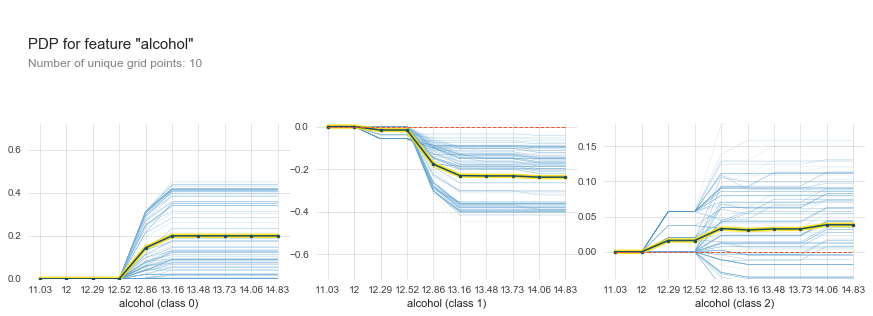

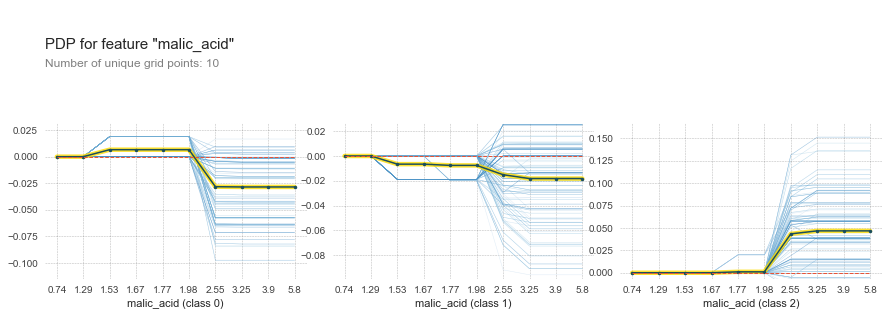

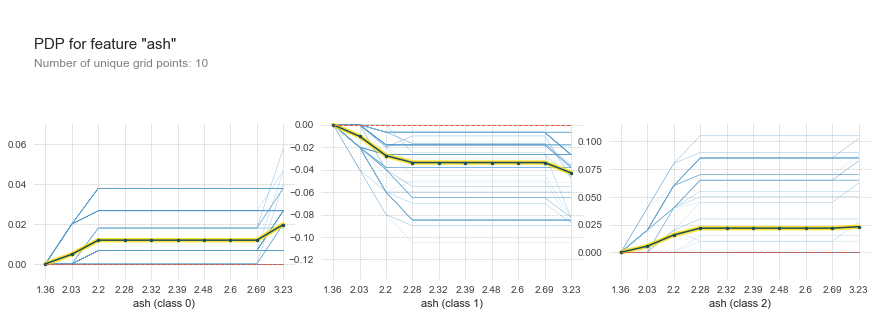

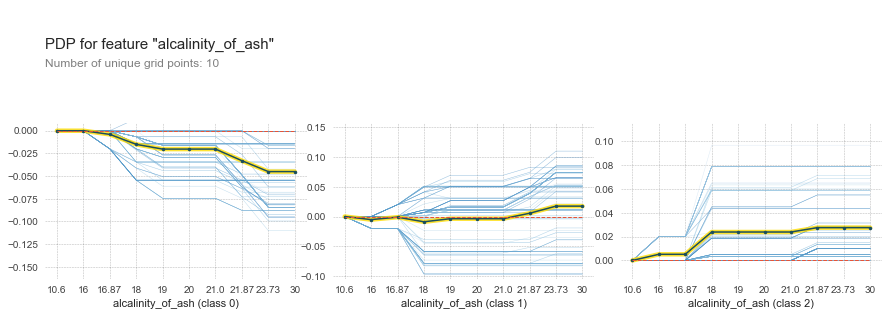

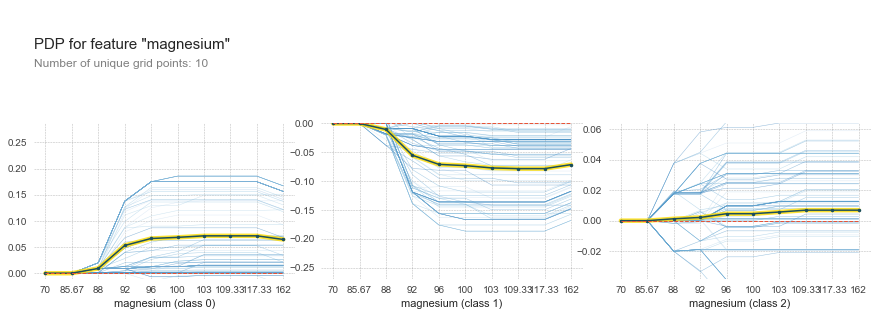

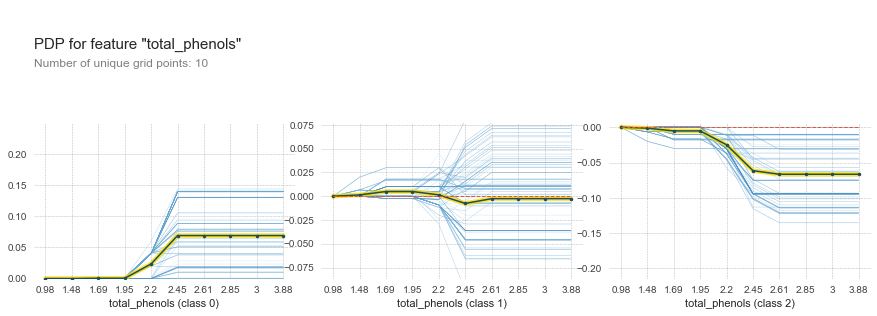

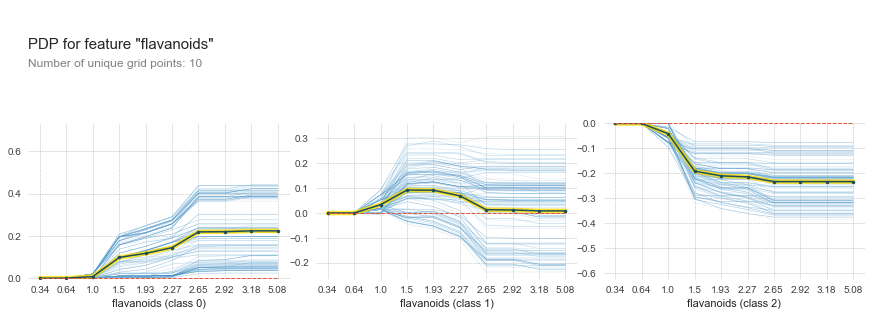

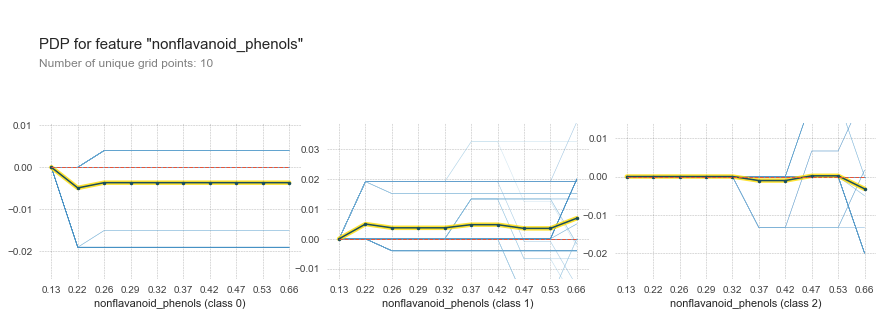

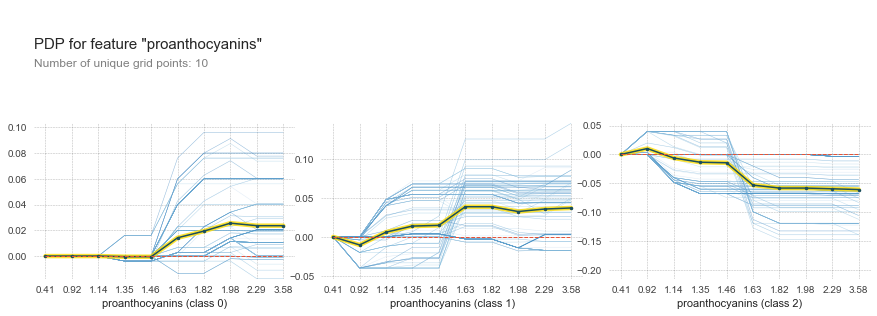

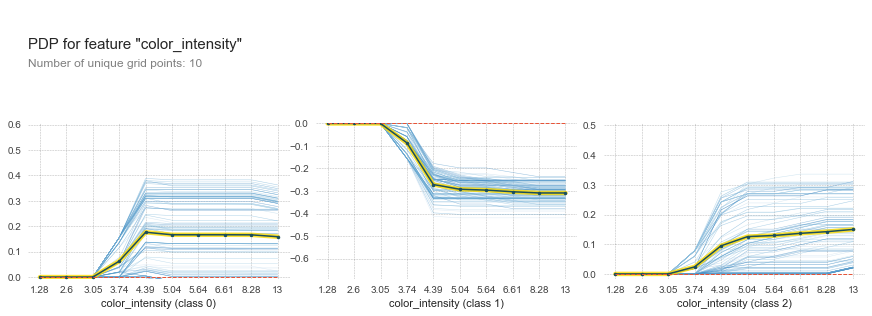

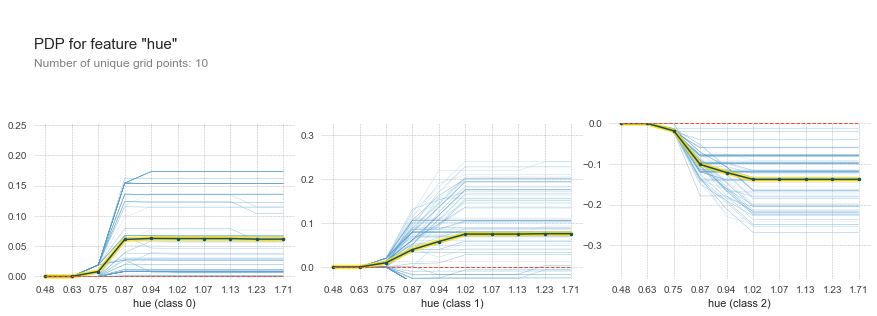

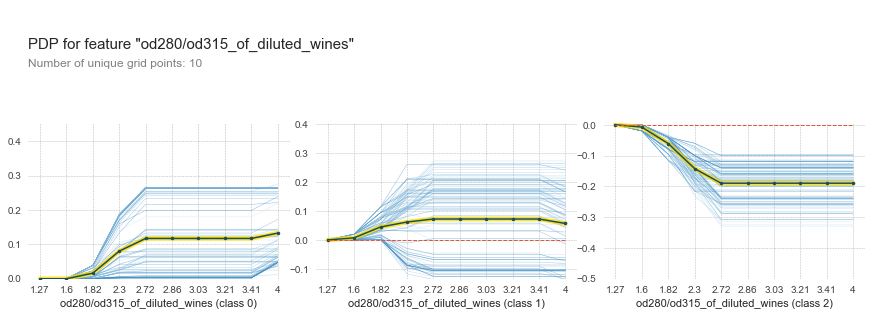

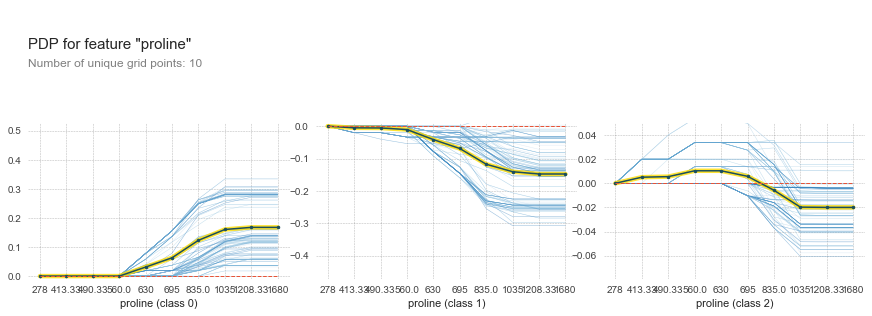

In [27]:
individual_pdp(rf_model, X_train.columns, df)

In [28]:
def interaction_pdp(model, feature_list, train_df, target_features):
    pdp_model = pdp.pdp_interact(model=model, dataset=train_df, model_features=feature_list, 
                                 features=target_features, num_grid_points=[10, 10], 
                                 percentile_ranges=[None, None], n_jobs=5)
    fig, axes = pdp.pdp_interact_plot(pdp_model, target_features, 
                                      plot_type='contour', x_quantile=True, ncols=2, plot_pdp=True)

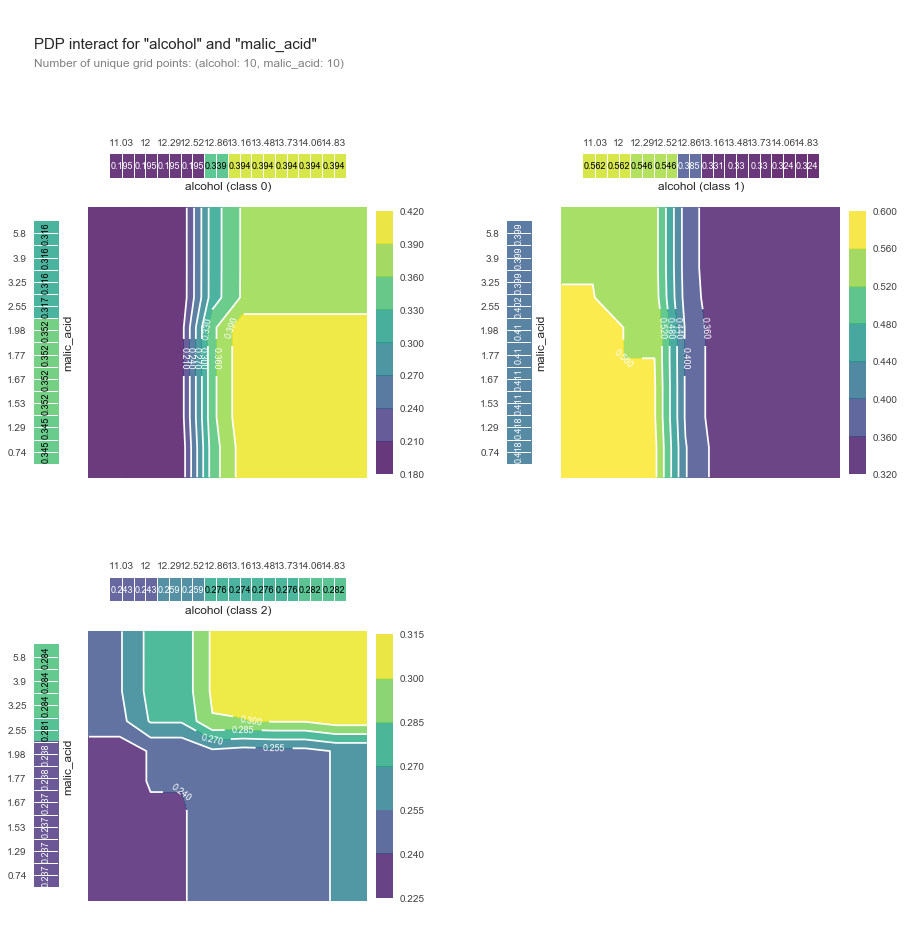

In [29]:
interaction_pdp(rf_model, features.columns, df, ['alcohol', 'malic_acid'])

In [36]:
# explain model using shap (shapley additive explanations), a better alternative to 'feature importance'
shap.initjs()

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_train)

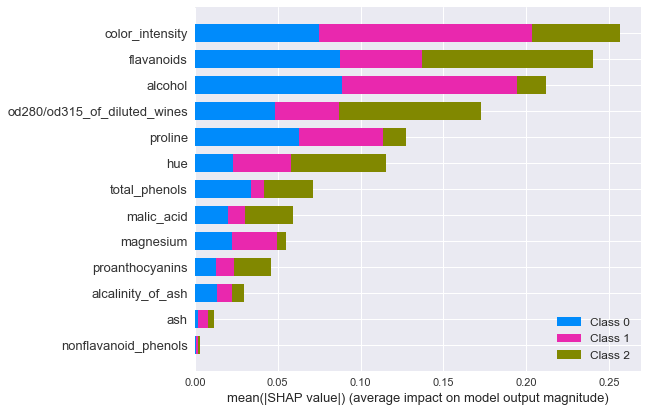

In [47]:
shap.summary_plot(shap_values, X_train)